# **3. DNN using PyTorch**
- DNN : Deep Neural Network
####<br>
- Reference의 예제 코드에서 내용 선정 및 발췌 후 정리 및 수정, 보완함
- Reference
  - 3분 딥러닝 파이토치맛

## 3-1. Fashion MNIST 데이터 셋 알아보기

In [3]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [4]:
ROOT_PATH = '/gdrive/My Drive/Colab Notebooks/Lectures/data/'

### 3-1-1. Fashion MNIST 데이터 셋

In [5]:
from torchvision import datasets, transforms, utils
from torch.utils import data

import matplotlib.pyplot as plt
import numpy as np

In [6]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [7]:
trainset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = True,
    download  = True,
    transform = transform
)
testset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = False,
    download  = True,
    transform = transform
)


Extracting ./.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw




Extracting ./.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw




Extracting ./.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw




Extracting ./.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [8]:
batch_size = 16

train_loader = data.DataLoader(
    dataset     = trainset,
    batch_size  = batch_size
)
test_loader = data.DataLoader(
    dataset     = testset,
    batch_size  = batch_size
)

In [9]:
dataiter       = iter(train_loader)
images, labels = next(dataiter)

### 3-1-2. 멀리서 살펴보기


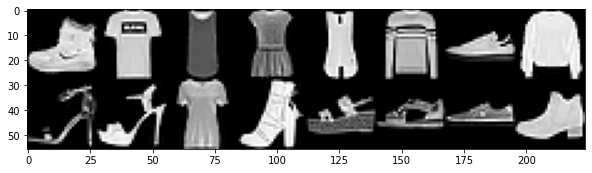

In [10]:
img   = utils.make_grid(images, padding=0)
npimg = img.numpy()
plt.figure(figsize=(10, 7))
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.show()

In [11]:
print(labels)

tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9])


In [12]:
CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}


for label in labels:
    index = label.item()
    print(CLASSES[index])

Ankle boot
T-shirt/top
T-shirt/top
Dress
T-shirt/top
Pullover
Sneaker
Pullover
Sandal
Sandal
T-shirt/top
Ankle boot
Sandal
Sandal
Sneaker
Ankle boot


### 3-1-3. 가까이서 살펴보기


(28, 28)


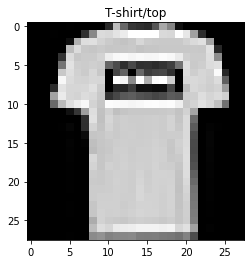

In [13]:
idx = 1

item_img = images[idx]
item_npimg = item_img.squeeze().numpy()
plt.title(CLASSES[labels[idx].item()])
print(item_npimg.shape)
plt.imshow(item_npimg, cmap='gray')
plt.show()

## 3-2. 인공신경망으로 패션 아이템 분류하기

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets

In [15]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

In [16]:
EPOCHS = 30
BATCH_SIZE = 64

### 3-2-1. 데이터셋 불러오기

In [17]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [18]:
trainset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = True,
    download  = True,
    transform = transform
)

testset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = False,
    download  = True,
    transform = transform
)

train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
)

test_loader = torch.utils.data.DataLoader(
    dataset     = testset,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
)

### 3-2-2. 신경망으로 Fashion MNIST 학습하기
- 입력 `x` 는 `[배치크기, 색, 높이, 넓이]`로 이루어짐
- `x.size()`는 [64, 1, 28, 28]
- Fashion MNIST에서 이미지의 크기는 28 x 28 (=784), 색은 흑백으로 1 가지
- 사용할 모델은 3개의 레이어를 가진 인공신경망
####<br>
- 모델 준비
  - `to()` 함수는 모델의 파라미터들을 지정한 곳으로 보내는 역할
  - 일반적으로 CPU 1개만 사용할 경우 필요는 없지만, GPU를 사용하고자 하는 경우 `to("cuda")`로 지정하여 GPU로 보내야 함
  - 지정하지 않을 경우 계속 CPU에 남아 있게 되며 빠른 훈련의 이점을 누리실 수 없음
  - 최적화 알고리즘(Optimizer)으로는 파이토치에 내장되어 있는 `optim.SGD`를 사용

In [19]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [20]:
model        = Net().to(DEVICE)
optimizer    = optim.SGD(model.parameters(), lr=0.01)

- 학습

In [21]:
def train(model, train_loader, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # 학습 데이터를 DEVICE의 메모리로 보냄
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

- 테스트

In [22]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            # 모든 오차 더하기
            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()
            
            # 가장 큰 값을 가진 클래스가 모델의 예측입니다.
            # 예측과 정답을 비교하여 일치할 경우 correct에 1을 더합니다.
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

- 실행

In [23]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

[1] Test Loss: 0.8291, Accuracy: 68.89%
[2] Test Loss: 0.6672, Accuracy: 75.08%
[3] Test Loss: 0.5825, Accuracy: 79.37%
[4] Test Loss: 0.5531, Accuracy: 79.90%
[5] Test Loss: 0.5061, Accuracy: 81.87%
[6] Test Loss: 0.4966, Accuracy: 82.11%
[7] Test Loss: 0.4943, Accuracy: 82.06%
[8] Test Loss: 0.4810, Accuracy: 83.25%
[9] Test Loss: 0.4570, Accuracy: 83.77%
[10] Test Loss: 0.4629, Accuracy: 83.39%
[11] Test Loss: 0.4575, Accuracy: 83.79%
[12] Test Loss: 0.4321, Accuracy: 84.81%
[13] Test Loss: 0.4333, Accuracy: 84.53%
[14] Test Loss: 0.4260, Accuracy: 84.89%
[15] Test Loss: 0.4392, Accuracy: 84.38%
[16] Test Loss: 0.4219, Accuracy: 84.94%
[17] Test Loss: 0.4083, Accuracy: 85.47%
[18] Test Loss: 0.4062, Accuracy: 85.70%
[19] Test Loss: 0.4142, Accuracy: 85.15%
[20] Test Loss: 0.4051, Accuracy: 85.64%
[21] Test Loss: 0.4271, Accuracy: 84.85%
[22] Test Loss: 0.3898, Accuracy: 86.22%
[23] Test Loss: 0.3885, Accuracy: 86.24%
[24] Test Loss: 0.4001, Accuracy: 85.50%
[25] Test Loss: 0.3845, A

## 3-3. 과적합과 정규화
- Overfitting and Regularization

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets

In [25]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

In [26]:
EPOCHS = 50
BATCH_SIZE = 64

### 3-3-1. 데이터셋에 노이즈 추가

original.png

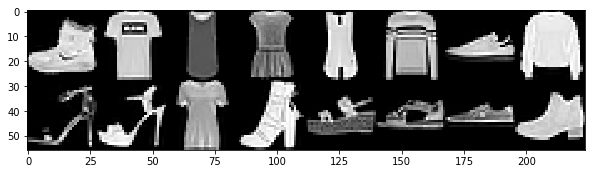

horizontalflip.png

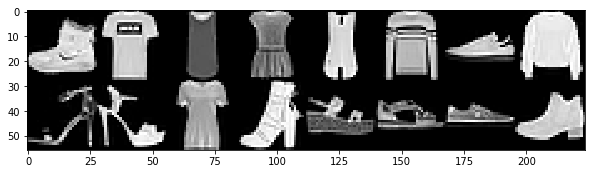

In [27]:
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./.data',
                   train=True,
                   download=True,
                   transform=transforms.Compose([
                       transforms.RandomHorizontalFlip(),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./.data',
                   train=False, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)

## 3-3-2. 신경망으로 Fashion MNIST 학습
- 입력 `x` 는 `[배치크기, 색, 높이, 넓이]`로 이루어져 있습니다.
- `x.size()`를 해보면 `[64, 1, 28, 28]`이라고 표시되는 것을 보실 수 있습니다.
- Fashion MNIST에서 이미지의 크기는 28 x 28, 색은 흑백으로 1 가지 입니다.
- 그러므로 입력 x의 총 특성값 갯수는 28 x 28 x 1, 즉 784개 입니다.
- 우리가 사용할 모델은 3개의 레이어를 가진 뉴럴네트워크 입니다. 

In [28]:
class Net(nn.Module):
    def __init__(self, dropout_p=0.2):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        # 드롭아웃 확률
        self.dropout_p = dropout_p

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        # 드롭아웃 추가
        x = F.dropout(x, training=self.training,
                      p=self.dropout_p)
        x = F.relu(self.fc2(x))
        # 드롭아웃 추가
        x = F.dropout(x, training=self.training,
                      p=self.dropout_p)
        x = self.fc3(x)
        return x

- 모델 준비
  - `to()` 함수는 모델의 파라미터들을 지정한 곳으로 보내는 역할을 합니다.
  - 일반적으로 CPU 1개만 사용할 경우 필요는 없지만,
  - GPU를 사용하고자 하는 경우 `to("cuda")`로 지정하여 GPU로 보내야 합니다.
  - 지정하지 않을 경우 계속 CPU에 남아 있게 되며 빠른 훈련의 이점을 누리실 수 없습니다.
  - 최적화 알고리즘으로 파이토치에 내장되어 있는 `optim.SGD`를 사용하겠습니다.

In [29]:
model        = Net(dropout_p=0.2).to(DEVICE)
optimizer    = optim.SGD(model.parameters(), lr=0.01)

- 학습

In [30]:
def train(model, train_loader, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

- 테스트


In [31]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()
            
            # 맞춘 갯수 계산
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

- 실행

In [32]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

[1] Test Loss: 0.6283, Accuracy: 78.10%
[2] Test Loss: 0.5306, Accuracy: 81.17%
[3] Test Loss: 0.4841, Accuracy: 82.58%
[4] Test Loss: 0.4615, Accuracy: 83.43%
[5] Test Loss: 0.4400, Accuracy: 84.07%
[6] Test Loss: 0.4249, Accuracy: 84.63%
[7] Test Loss: 0.4190, Accuracy: 84.58%
[8] Test Loss: 0.4059, Accuracy: 85.26%
[9] Test Loss: 0.3954, Accuracy: 85.54%
[10] Test Loss: 0.3856, Accuracy: 85.81%
[11] Test Loss: 0.3825, Accuracy: 86.30%
[12] Test Loss: 0.3780, Accuracy: 86.21%
[13] Test Loss: 0.3816, Accuracy: 85.91%
[14] Test Loss: 0.3656, Accuracy: 86.60%
[15] Test Loss: 0.3607, Accuracy: 86.94%
[16] Test Loss: 0.3572, Accuracy: 87.03%
[17] Test Loss: 0.3606, Accuracy: 86.90%
[18] Test Loss: 0.3513, Accuracy: 87.30%
[19] Test Loss: 0.3516, Accuracy: 87.20%
[20] Test Loss: 0.3595, Accuracy: 86.54%
[21] Test Loss: 0.3449, Accuracy: 87.47%
[22] Test Loss: 0.3404, Accuracy: 87.50%
[23] Test Loss: 0.3452, Accuracy: 87.18%
[24] Test Loss: 0.3338, Accuracy: 87.90%
[25] Test Loss: 0.3321, A